In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [12]:
from tensorflow.keras.datasets import cifar10
train_ds, test_ds = cifar10.load_data() 
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)



In [9]:
def show_images(images):
    n = len(images)
    for i,image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

2026-02-02 22:11:58.110103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


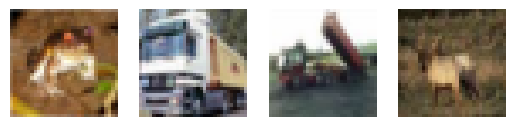

In [13]:
IMG_SIZE =32
resize_and_rescale = tf.keras.Sequential([
tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
tf.keras.layers.Rescaling(1/256)])
resized_images = train_ds.take(4).map(lambda x,y: resize_and_rescale(x))
show_images(resized_images)

2026-02-02 22:13:30.708338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3140622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3299153].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4170073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1794696].
2026-02-02 22:13:30.734054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


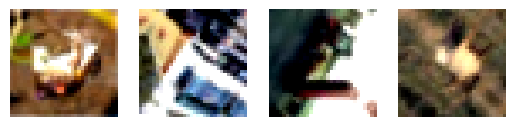

In [14]:
data_augumentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip(),
tf.keras.layers.RandomRotation(factor=.2),
tf.keras.layers.RandomContrast(factor=(.2,.9),),
])
aug_images = resized_images.map(lambda x: data_augumentation(x))
show_images(aug_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.040874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0469005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027770609..1.063392].
2026-02-02 22:15:11.330106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


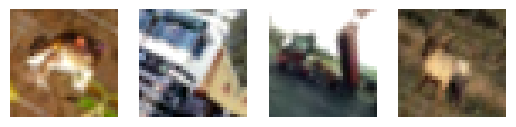

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    ds = ds.map(lambda x,y:
(resize_and_rescale(x),y),num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y:
(data_augumentation(x),y),num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)
prepared_ds = prepare(train_ds.take(4)) 
show_images(prepared_ds.map(lambda x,y:x))

In [21]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(32,32, input_shape=(32,32,3)),
    tf.keras.layers.Rescaling(1/256)
])

data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augumentation,
    tf.keras.layers.Conv2D(16,3),
    tf.keras.layers.MaxPooling2D(),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy'
)


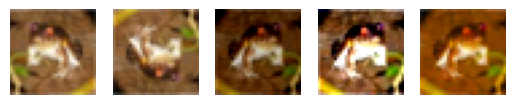

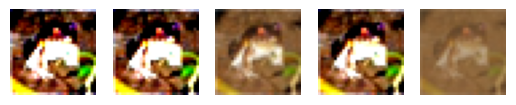

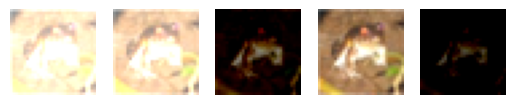

In [22]:
image , label = next(iter(train_ds))
show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image,-.2),
    tf.image.adjust_contrast(image,2),
    tf.image.adjust_saturation(image,2),
]) 
show_images([
    tf.image.stateless_random_contrast(image, lower=.1,upper=5,seed = (i,0))
    for i in range(1,6)
]) 
show_images([
    tf.image.stateless_random_brightness(image, max_delta=.8,seed = (i,0))
    for i in range(1,6)
]) 

In [23]:
def resize_and_rescale(img):
    img = tf.cast(img,tf.float32) 
    img = tf.image.resize(img,(32,32))
    img = img/255.0 
    return img
def augument(img_label,seed):
    image,label = img_label
    image = resize_and_rescale(image)
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE,3], seed=seed)
    image = tf.image.stateless_random_brightness( image, max_delta=0.5,seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image,label
    

In [24]:
rng = tf.random.Generator.from_seed(1,alg="philox")

In [25]:
def augument_wrapper(image,label):
    seed = rng.make_seeds(2)[0] 
    image,label = augument((image,label),seed)
    return image,label

2026-02-02 22:29:35.140815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


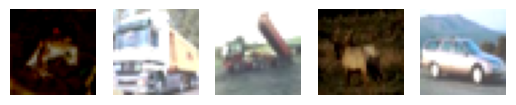

In [26]:
augumented_ds = train_ds.take(5).map(augument_wrapper)
show_images(augumented_ds.map(lambda x,y : x))